In [1]:
#clear all variables from workspace
%reset -f 
%whos

Interactive namespace is empty.


In [ ]:
#load all relevant modules and packages etc

#%reset
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

#Misc
import time, os, sys, pdb
from glob import glob
from fnmatch import fnmatch

#Base
import numpy as np
import pandas as pd
import math as m
import scipy.io as sio
import scipy.stats as st
from scipy.ndimage import gaussian_filter1d
from scipy.stats import zscore

#Save
import json
import scipy.io as sio
import h5py

#Plot
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import cv2
from PIL import Image
from matplotlib import cm
from matplotlib.backends.backend_pdf import PdfPages
sns.set_style("ticks")

#Model
import ssm

#CCM
#from DelayEmbedding import DelayEmbedding as DE

#User
#import util
#import plotting as usrplt

import warnings
warnings.filterwarnings("ignore")


In [ ]:
#set name suffix for saved files and directory in which to save them

fsuffix='4022_210806_E267_2_00001_00001'
PlotDir = os.path.join('G:\\uobrainflex_analysis_2022\\A1V1M2\\passive_visual',fsuffix)

In [100]:
#Make sure all your file suffixes and save folders etc are correct

save_folder==PlotDir

print(PlotDir)
print(fsuffix)
PlotDir = os.path.join('I:\\uobrainflex_analysis_2022\\meso_sci_ppr_I_2022\\plots',fsuffix)
#PlotDir='I:\uobrainflex_analysis_2022\meso_sci_ppr_I_2022\plots\3056_200924_E235_1_00003_00001'
print(PlotDir)
print(save_folder)

I:\uobrainflex_analysis_2022\meso_sci_ppr_I_2022\plots\3056_201005_E235_2_00002_00001
3056_201005_E235_2_00002_00001
I:\uobrainflex_analysis_2022\meso_sci_ppr_I_2022\plots\3056_201005_E235_2_00002_00001


In [323]:
#move current folder to PlotDir folder

if not os.path.isdir(PlotDir):
    os.makedirs(PlotDir)

NameError: name 'PlotDir' is not defined

In [27]:
#set some defaults just in case

Spike2_exist='yes'
ROI_num=1
ppl_cam_rate=30
sound_rate=50000

In [10]:
#create nifty function for loading in dictionaries containing different types of data variables

def getList(dict):
      
    return [*dict]

if Spike2_exist.lower()=="yes":
    behav_dict_keys = list(behav_dict)
    
ops_keys = list(ops)
for i in range(len(getList(ops))):
    print(ops_keys[i])

look_one_level_down
fast_disk
delete_bin
mesoscan
h5py
h5py_key
save_path0
subfolders
nplanes
nchannels
functional_chan
tau
fs
force_sktiff
preclassify
save_mat
combined
aspect
do_bidiphase
bidiphase
do_registration
keep_movie_raw
nimg_init
batch_size
maxregshift
align_by_chan
reg_tif
reg_tif_chan2
subpixel
smooth_sigma
th_badframes
pad_fft
nonrigid
block_size
snr_thresh
maxregshiftNR
1Preg
spatial_hp
pre_smooth
spatial_taper
roidetect
sparse_mode
diameter
spatial_scale
connected
nbinned
max_iterations
threshold_scaling
max_overlap
high_pass
inner_neuropil_radius
min_neuropil_pixels
allow_overlap
chan2_thres
baseline
win_baseline
sig_baseline
prctile_baseline
neucoeff
xrange
yrange
data_path
save_path
ops_path
reg_file
first_tiffs
frames_per_folder
filelist
nframes
meanImg
Ly
Lx
yblock
xblock
nblocks
NRsm
refImg
yoff
xoff
corrXY
yoff1
xoff1
corrXY1
badframes
regPC
regDX
tPC
spatscale_pix
max_proj
Lyc
Lxc
Vcorr
sdmov
meanImgE


What is the resolution, in micrometers per pixel: 5


(924, 1000)


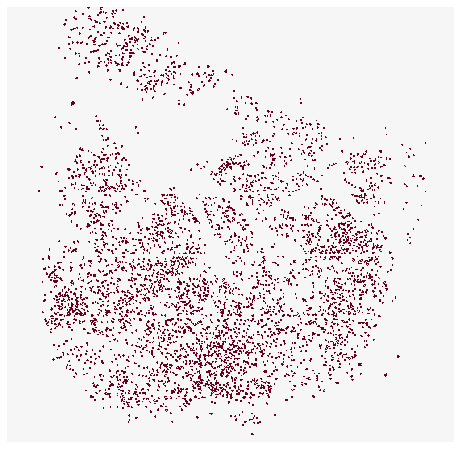

In [28]:
#maps cell locations, only run this if you have a mesoscope session already run through suite2p that you're looking at right now

res_int = float(input("What is the resolution, in micrometers per pixel:"))
#res_int = 5 #Resolution, in micrometers per pixel
im = np.zeros((ops['Lx'], ops['Ly']))

for n in range(0,nROIs):
    #print(n)
    if iscell[n,0]==1:
        #print(n)
        ypix = stat[n]['ypix'][~stat[n]['overlap']]#*res_int
        xpix = stat[n]['xpix'][~stat[n]['overlap']]#*res_int
        if (iscell[n,0] == 1) & (iscell[n,1] > 0.50):
            #print(n)
            im[xpix,ypix] = 1
        else:
            im[xpix,ypix] = -1

fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(im,ax=ax,cmap='RdBu_r',center=0,cbar=False)#,color_continuous_scale='RdBu_r')
print(im.shape)

plt.imsave(os.path.join(PlotDir,'neural-location_real_{}_MMM.png'.format(fsuffix)),im)

ax.axis('off')
plt.savefig(os.path.join(PlotDir,'neural-location_{}.png'.format(fsuffix)))

In [29]:
#creates several imaging related functions that you need

# -*- coding: utf-8 -*-
"""
Created on Thu Dec 16 11:30:51 2021
@author: admin
"""

import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from skimage.measure import block_reduce
from skimage.transform import PiecewiseAffineTransform, warp
from skimage.filters import gaussian
from scipy import ndimage
import scipy.ndimage.morphology as ni

def import_multi_tif(tif_folder, n_channels=2, down_sample_factor= 2):
    tif_filepaths = glob.glob(os.path.join(tif_folder + '\*.tif'))
    print('\n' + str(len(tif_filepaths)) + ' file(s) to process')
    for i, image_path in enumerate(tif_filepaths):
        im = io.imread(image_path)
        if n_channels==2:
            if i == 0:
                wf_blue = np.ndarray([0, int(im.shape[1]/down_sample_factor), int(im.shape[2]/down_sample_factor)])
                wf_green = np.ndarray([0, int(im.shape[1]/down_sample_factor), int(im.shape[2]/down_sample_factor)])
                
            first = np.atleast_3d(block_reduce(im[np.arange(0,len(im),2)],(1,down_sample_factor,down_sample_factor),func=np.mean))
            second = np.atleast_3d(block_reduce(im[np.arange(1,len(im),2)],(1,down_sample_factor,down_sample_factor),func=np.mean))
            if wf_blue.shape[0] == wf_green.shape[0]:
                wf_blue = np.append(wf_blue, first, axis=0)
                wf_green = np.append(wf_green, second, axis=0)
            else:
                wf_blue = np.append(wf_blue, second, axis=0)
                wf_green = np.append(wf_green, first, axis=0)                  
        print('\nFile ' + str(i+1) + ' of ' + str(len(tif_filepaths)) + ' complete')
    return wf_blue, wf_green

def set_transform_anchors(stationary_image, warp_image):
    figure = plt.figure()
    ax = plt.subplot(1,2,1)
    ax.imshow(stationary_image)
    ax2 = plt.subplot(1,2,2)
    ax2.imshow(warp_image)
    
    plt.suptitle('Set points to anchor transformation\n'+
                 'Select point on left then right image for each anchor\n'+
                 'left click to select | right click to cancel last select | middle click to complete')
    points = np.array(plt.ginput(100,timeout=300))

    stationary_points = points[np.array(range(0,len(points),2),dtype=int)]
    warp_points = points[np.array(range(1,len(points),2),dtype=int)]
    ax.scatter(stationary_points[:,0],stationary_points[:,1],color='b')
    for idx in range(len(stationary_points)):
        ax.text(stationary_points[idx][0],stationary_points[idx][1],str(idx),color='r')
    ax2.scatter(warp_points[:,0],warp_points[:,1],color='b')
    for idx in range(len(warp_points)):
        ax2.text(warp_points[idx][0],warp_points[idx][1],str(idx),color='r')
    plt.pause(0.1)
    return stationary_points, warp_points, figure

def transform_image(stationary_image,warp_image,stationary_points, warp_points):
    tform = PiecewiseAffineTransform()
    tform.estimate(stationary_points, warp_points)
    out_rows = stationary_image.shape[0]
    out_cols = stationary_image.shape[1]
    warped_image = warp(warp_image, tform, output_shape=(out_rows, out_cols))
    return warped_image

def smooth_masks(masks):
    for i in range(masks.shape[0]):
        img = masks[i,:,:]
        dst = gaussian(1-img,sigma=(1))
        dst[dst<=.01]=1
        dst[dst<.1]=0
        masks[i,:,:]=dst
    return masks

def reduce_mask_overlap(masks):
    for i in range(masks.shape[0]):
        this_mask = masks[i,:,:]
        other_masks = masks[np.where([np.arange(masks.shape[0])!=i])[1],:,:]
        other_masks_merge = np.max(other_masks,axis=0)
        overlap = np.where((this_mask+other_masks_merge)>1)
        this_mask[overlap[0],overlap[1]]=0
        masks[i,:,:]=this_mask
    return masks

def masks_to_outlines(masks):
    outlines = np.zeros(masks.shape,dtype=np.int8)
    for i in range(outlines.shape[0]):
        mask = masks[i,:,:]
        outlines[i,:,:] = mask - ni.binary_erosion(mask)
    return outlines

def rotate_3d_matrix(array_3d,angle = 22.5):   
    this_slice = array_3d[0,:,:]
    this_rotated = ndimage.rotate(this_slice, angle, reshape=True)
    rotated_matrix = np.ndarray([array_3d.shape[0],this_rotated.shape[0],this_rotated.shape[1]],dtype=np.int8)
    for idx in range(array_3d.shape[0]):
        this_slice = array_3d[idx,:,:]
        if len(np.where(this_slice==1)[0])>0:
            this_rotated = ndimage.rotate(this_slice, angle, reshape=True)
            this_rotated[this_rotated>=.2]=1
            this_rotated[this_rotated<.2]=0
            rotated_matrix[idx,:,:] = this_rotated
    return rotated_matrix

def surface_projection(volume):
    shell_volume = np.zeros(volume.shape,np.int8)
    for ii in range(volume.shape[0]):
        for jj in range(volume.shape[2]):
            zplane = np.where(volume[ii,:,jj]>0)[0]
            if len(zplane)>0:
                shell_volume[ii,zplane[0],jj] = 1
    return shell_volume

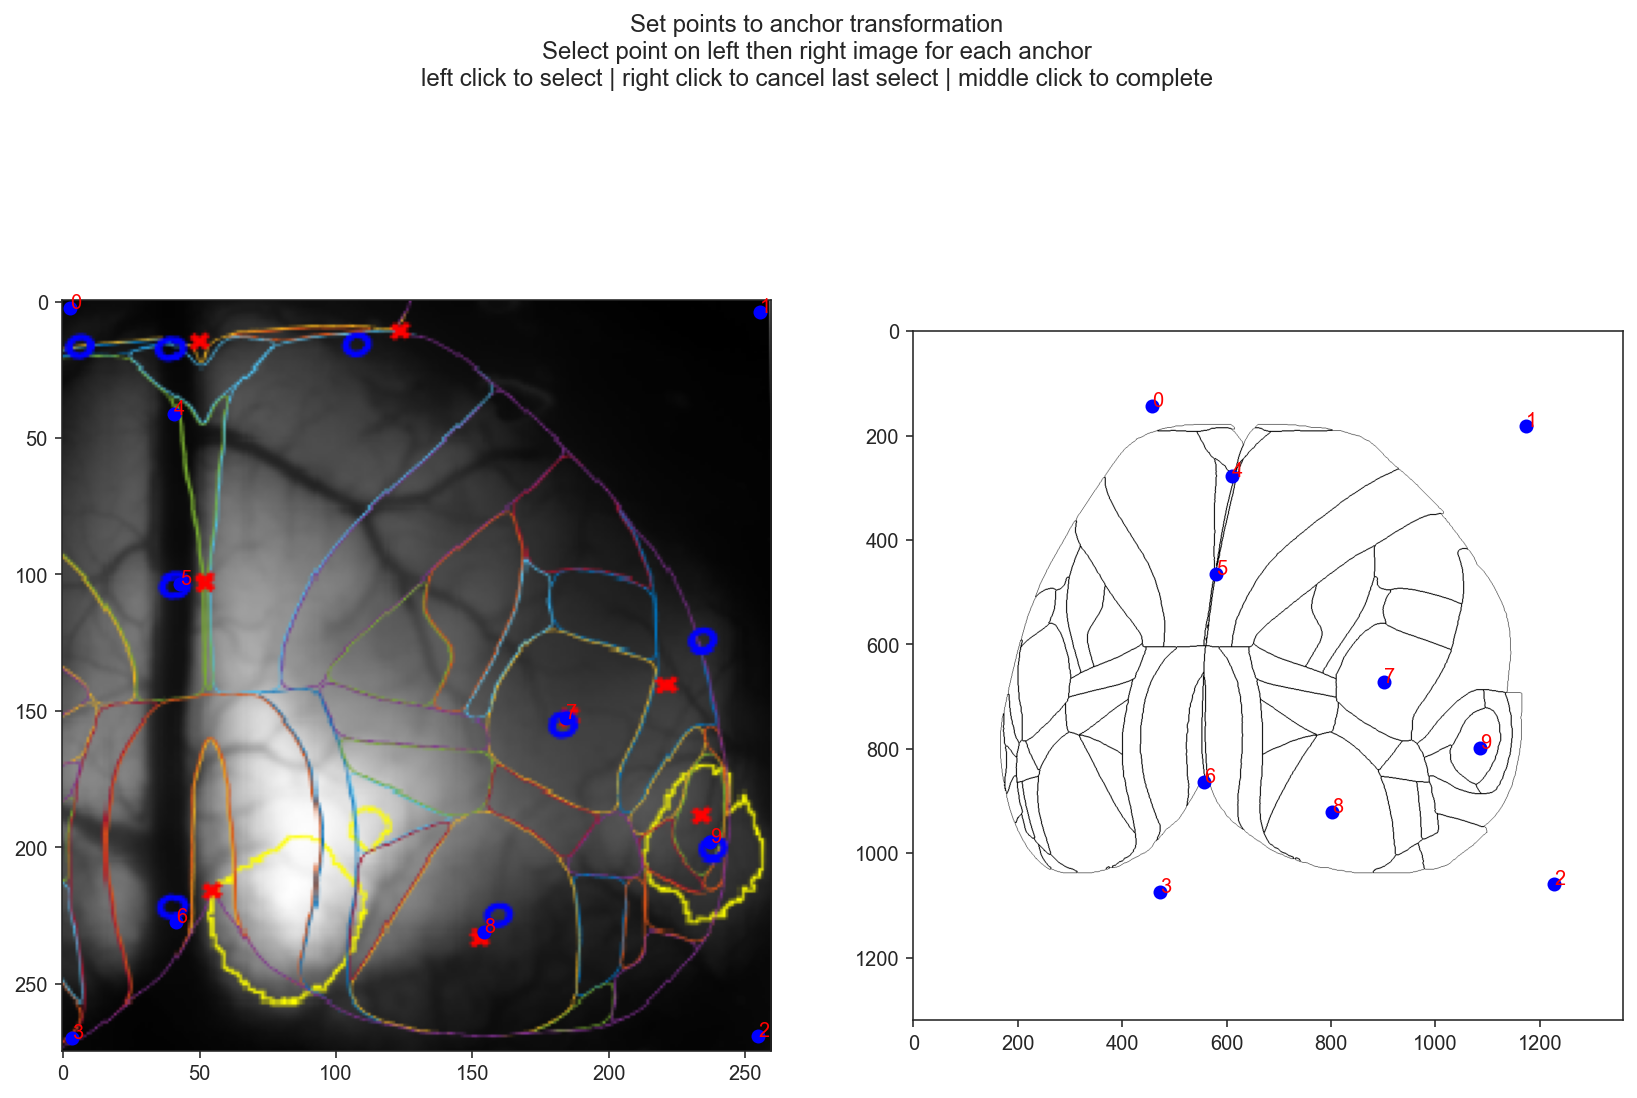

In [30]:
#Runs first part of session alignment (MMM to CCF)

# -*- coding: utf-8 -*-
"""
Created on Thu Dec 16 17:09:27 2021
@author: Daniel Hulsey
this script is used to align a CCF to a multimodalmapping session. Points selected to align the ccf will be saved for future use.
"""

import os
from skimage import io
#import uobrainflex.utils.image_utilities as im_util
import matplotlib.pyplot as plt
import numpy as np
import tkinter as tk
from tkinter import filedialog

%matplotlib qt
import matplotlib.pyplot as plt

root = tk.Tk()
root.withdraw()

mmm_title = 'Select multi modal map image'
mmm_dir = 'C:\\Users\\admin\\Desktop\\figure dump\\CCF'
mmm_image_path = filedialog.askopenfilename(title = mmm_title, initialdir = mmm_dir)

##hardcode this? or put it in conf file?
ccf_title = 'Select CCF image'
ccf_dir = 'C:\\Users\\admin\\Desktop\\figure dump\\CCF'
ccf_file_path = filedialog.askopenfilename(title = ccf_title, initialdir = ccf_dir)


save_folder = os.path.dirname(mmm_image_path)
subject = os.path.basename(mmm_image_path)
subject = subject[:subject.find("_")]


mmm_image = io.imread(mmm_image_path)
ccf_image = io.imread(ccf_file_path)
mmm_points, ccf_points, figure = set_transform_anchors(mmm_image, ccf_image)

plt.savefig(save_folder + '/' + subject +'_mmm_ccf_fit.png')
np.save(save_folder + '/' + subject + '_mmm_points',mmm_points)
np.save(save_folder + '/' + subject + '_ccf_points',ccf_points)

plt.savefig(os.path.join(PlotDir,'_mmm_ccf_fit_{}.png'.format(fsuffix)))
np.save(os.path.join(PlotDir,'_mmm_points_{}'.format(fsuffix)),mmm_points)
np.save(os.path.join(PlotDir,'_ccf_points_{}'.format(fsuffix)),ccf_points)

In [35]:
#Runs second part of session alignment (mesoscope suite2p session output to MMM, then CCF to session via MMM)

# -*- coding: utf-8 -*-
"""
Created on Thu Dec 16 17:09:27 2021
@author: Daniel Hulsey
this script aligns a ccf to an individual session, and extracts dff data for each indicated region. 
Running it fully requires:
    1. saved dff trace for the session being analyzed
    2. saved points to align CCF to multimodalmap session
    3. blood vessel images from the CCF and session for analysis for alignment
Save location for the region dff traces needs to be better defined    
"""

from skimage import io
#import uobrainflex.utils.image_utilities as im_util

import numpy as np
import tkinter as tk
from tkinter import filedialog
import glob 
from PIL import Image

%matplotlib qt
import matplotlib.pyplot as plt

def area_mean_dff(dff,pixel_list):
    xs = pixel_list[0,:]
    ys = pixel_list[1,:]
    return np.mean(dff[:,xs,ys],axis=1)

def area_max_dff(dff,pixel_list):
    xs = pixel_list[0,:]
    ys = pixel_list[1,:]
    return np.max(dff[:,xs,ys],axis=1)

# select folders and align session and mmm vessel images
newfolders=''
while newfolders != 'n': # repeat until user indicates that new folders should not be selected
    
    subject_title = 'select subject mmm folder'
    session_title = 'select session folder'
    root = tk.Tk()
    root.withdraw()
    subject_folder = filedialog.askdirectory(title = subject_title)
    session_folder = filedialog.askdirectory(title = session_title)
    save_folder = session_folder
    

    mmm_image_path = glob.glob(subject_folder + '/*MMM.png')[0]
    
    # session_vessels_path = glob.glob(subject_folder + '/*vessel*')[0] ## this is the future one. below for testing
    session_vessels_path = glob.glob(session_folder + '/*MMM.png')[0]
        
    mmm_image = io.imread(mmm_image_path)
    vessel_image = io.imread(session_vessels_path)
    
    repeat_align=''
    while repeat_align != 'n': # repeat until user replys to not
        session_vessel_points, session_mmm_points, figure = set_transform_anchors(vessel_image, mmm_image)
        plt.savefig(save_folder +'\mmm_to_session_align.png')
        repeat_align = input("repeat alignment with these images? Y/n\n")
    newfolders = input("repeat alignment with different folder selections? Y/n\n")
    

plt.savefig(save_folder +'\mmm_to_session_align.png')
np.save(save_folder + '\session_mmm_points',session_mmm_points)
np.save(save_folder + '\session_vessel_points',session_vessel_points)

# # Now grab MMM & CCF alignments & DFF, create session masks, and grab mean region dffs
# print('loading dff data')
# # dff_filepath =  glob.glob(session_folder + '/*dff.npy')[0] # this is real one to use. hardcoded to demo with no real data
# dff_filepath =  'T:/BW048_211013_115911/WF_raw/WF_raw_dff.npy'
# dff = np.load(dff_filepath)

mmm_points_filepath = glob.glob(subject_folder + '/*mmm_points.npy')[0]
ccf_points_filepath = glob.glob(subject_folder + '/*ccf_points.npy')[0]
masks_filepath = 'C:\\Users\\McCormick Lab\\Documents\\Python\\Hulsey_A1V1M2_CCF_affine_Jan1122\\22deg\\masks.npy'
areas_filepath = 'C:\\Users\\McCormick Lab\\Documents\\Python\\Hulsey_A1V1M2_CCF_affine_Jan1122\\22deg\\areas.npy'

mmm_points = np.load(mmm_points_filepath)
ccf_points = np.load(ccf_points_filepath)
masks = np.load(masks_filepath)
areas = np.load(areas_filepath)


# st2, wp2 = set_transform_anchors(session_vessels, mmm_vessels)

print('aligning ccf regions')
session_masks=[]
mmm_masks=[]
for i, mask in enumerate(masks):
    mmm_mask = transform_image(mmm_image, mask, mmm_points, ccf_points)
    mmm_mask[mmm_mask<.01]=0
    mmm_mask[mmm_mask>0]=1
    mmm_masks.append(mmm_mask)
    
    session_mask = transform_image(vessel_image, mmm_mask, session_vessel_points, session_mmm_points)
    session_mask[session_mask<.01]=0
    session_mask[session_mask>0]=1
    
    session_masks.append(session_mask)
session_masks = np.array(session_masks)

mmm_masks = np.array(mmm_masks)

plt.figure()
plt.imshow(np.sum(session_masks,axis=0))

plt.imshow(mmm_mask)
plt.imshow(mask)

session_masks = reduce_mask_overlap(session_masks)

plt.figure()
plt.imshow(np.sum(session_masks,axis=0))

outlines=masks_to_outlines(session_masks)
plt.figure()
plt.imshow(np.sum(outlines,axis=0))

outlines_pil=Image.fromarray(np.sum(outlines,axis=0)*255)
plt.figure()
outlines_pil.show()

plt.figure()
plt.imshow(vessel_image)
plt.imshow(np.sum(outlines,axis=0),cmap="gray")

vessel_outlines=vessel_image
outlines_flat=np.sum(outlines,axis=0)*255

for i in range(len(vessel_image[:,0,0])):
    for j in range(len(vessel_image[0,:,0])):
        if outlines_flat[i,j]>0:
            vessel_outlines[i,j,:]=255

plt.figure()
plt.imshow(vessel_outlines)
plt.savefig(save_folder +'\ccf_to_session_align_meso.tif',dpi=600,format='tif')

vessel_outlines_swap = vessel_outlines.transpose(1, 0, 2)
plt.figure()
plt.imshow(vessel_outlines_swap)
plt.savefig(save_folder +'\ccf_to_session_align_rotated.tif',dpi=600,format='tif')

# print('extracting are dff values')
# area_list = ['r_VISp','r_AUDp','r_MOs']
# for area in area_list:
#     # plt.figure()
#     mask_ind = np.where(areas==area)[0]
#     this_mask = session_masks[mask_ind,:,:][0].T
#     this_dff = area_mean_dff(dff,np.array(np.where(this_mask)))
#     np.save(save_folder + '/' + area + '_dff',this_dff)
    

repeat alignment with these images? Y/n
 n
repeat alignment with different folder selections? Y/n
 n


aligning ccf regions


In [52]:
#run this

mmm_mask = transform_image(mmm_image, mask, mmm_points, ccf_points)

In [46]:
#run this

session_vessel_points, session_mmm_points, figure = set_transform_anchors(vessel_image, mmm_image)
plt.savefig(save_folder +'\mmm_to_session_align.tif',dpi=600,format='tif')

NameError: name 'set_transform_anchors' is not defined

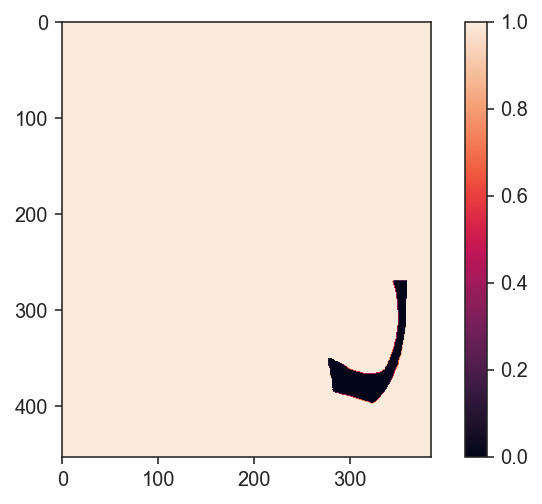

In [59]:
#run as test

plt.imshow(mmm_mask<.01)
plt.colorbar()

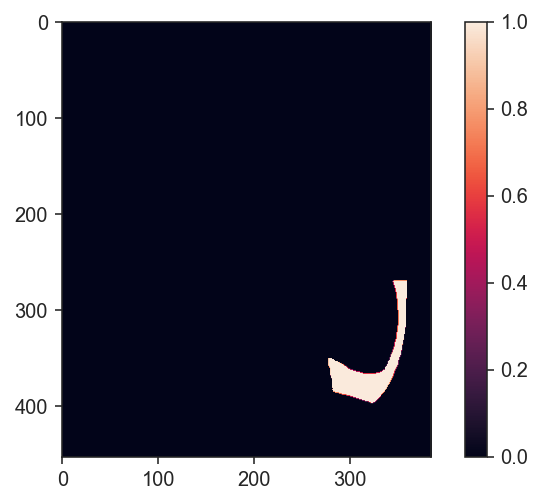

In [62]:
#run as test

mmm_mask2 = mmm_mask.copy()
mmm_mask2[mmm_mask2<.01]=0
mmm_mask2[mmm_mask2>0]=1
plt.imshow(mmm_mask2)
plt.colorbar()

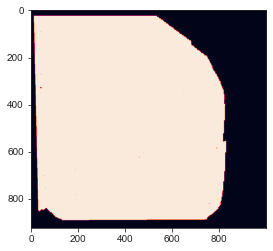

In [38]:
#run as test

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.imshow(np.sum(session_masks,axis=0))

['l_VISp' 'l_VISpl' 'l_VISpor' 'l_VISl' 'l_VISli' 'l_VISal' 'l_VISrl'
 'l_VISa' 'l_VISam' 'l_VISpm' 'l_FRP' 'l_PL' 'l_ACAd' 'l_MOs' 'l_MOp'
 'l_RSPv' 'l_RSPd' 'l_RSPagl' 'l_SSp-tr' 'l_SSp-ll' 'l_SSp-ul' 'l_SSp-m'
 'l_SSp-n' 'l_SSp-un' 'l_SSp-bfd' 'l_SSs' 'l_AUDp' 'l_AUDv' 'l_AUDd'
 'l_AUDpo' 'l_TEa' 'r_VISp' 'r_VISpl' 'r_VISpor' 'r_VISl' 'r_VISli'
 'r_VISal' 'r_VISrl' 'r_VISa' 'r_VISam' 'r_VISpm' 'r_FRP' 'r_PL' 'r_ACAd'
 'r_MOs' 'r_MOp' 'r_RSPv' 'r_RSPd' 'r_RSPagl' 'r_SSp-tr' 'r_SSp-ll'
 'r_SSp-ul' 'r_SSp-m' 'r_SSp-n' 'r_SSp-un' 'r_SSp-bfd' 'r_SSs' 'r_AUDp'
 'r_AUDv' 'r_AUDd' 'r_AUDpo' 'r_TEa']


Which area are you interested in: r_MOs


You have selected: r_MOs


What is the resolution, in micrometers per pixel: 5


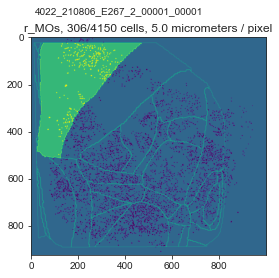

In [64]:
#run iff you have a suite2p processed mesoscope session you're working with right now

print(areas)
selected_area=input("Which area are you interested in:")
for i in range(len(areas)):
    if selected_area==areas[i]:
        area_num=i
        print("You have selected: "+selected_area)

res_int = float(input("What is the resolution, in micrometers per pixel:"))
#res_int = 5 #Resolution, in micrometers per pixel
im_restrict = np.zeros((ops['Lx'], ops['Ly']))

for n in range(0,nROIs):
    if iscell[n,0]==1:
        ypix = stat[n]['ypix'][~stat[n]['overlap']]#*res_int
        xpix = stat[n]['xpix'][~stat[n]['overlap']]#*res_int
        if (iscell[n,0] == 1) & (iscell[n,1] > 0.50) & (iscell_masks[n] == area_num):
            im_restrict[xpix,ypix] = 1
        else:
            im_restrict[xpix,ypix] = -1

#fig, ax = plt.subplots(figsize=(8,8))
#sns.heatmap(im,ax=ax,cmap='RdBu_r',center=0,cbar=False)#,color_continuous_scale='RdBu_r')
#plt.title(fsuffix+","+str(np.count_nonzero(iscell[:,0]))+" cells")
#print(im.shape)

#plt.imsave(os.path.join(PlotDir,'neural-location_real_'+areas[area_num]+'_{}.png'.format(fsuffix)),im)

#ax.axis('off')
#plt.savefig(os.path.join(PlotDir,'neural-location_'+areas[area_num]+'_{}.png'.format(fsuffix)))

#im_restrict_masked=im_restrict+session_masks[area_num,:,:]+outlines[area_num,:,:]
for i in range(len(im_restrict[:,0])):
    for j in range(len(im_restrict[0,:])):
        if outlines_flat[i,j]>0:
            im_restrict[i,j]=1

im_restrict_masked=im_restrict+session_masks[area_num,:,:]

cell_count=np.zeros(62,dtype='int')

for i in range(len(iscell_masks)):
    cell_count[int(iscell_masks[i])]=cell_count[int(iscell_masks[i])]+1

#plt.figure()
#plt.imshow(im_restrict,cmap='viridis')
#plt.title(selected_area+", "+str(cell_count[area_num])+" cells")

plt.figure()
plt.imshow(im_restrict_masked,cmap='viridis')
plt.title(selected_area+", "+str(cell_count[area_num])+"/"+str(np.count_nonzero(iscell[:,0]))+" cells, "+str(res_int)+" micrometers / pixel")
plt.text(15, -100, fsuffix)

plt.savefig(os.path.join(PlotDir,'neural-location_'+areas[area_num]+'_{}_masked.png'.format(fsuffix)),dpi=300,format='png')
plt.savefig(os.path.join(PlotDir,'neural-location_'+areas[area_num]+'_{}_masked.tif'.format(fsuffix)),dpi=300,format='tif')

In [948]:
#save all current variables (you will have to modify this...can run %whos to figure out which variables you have, then change items in save dictionary to match)

import time
timestr = time.strftime("%Y%m%d-%H%M%S")
print(timestr)
save_all_filename_npy=PlotDir+'\\nb_Chris_'+fsuffix+'_'+timestr+'.npy'
print(save_all_filename_npy)

pca=0

save_all_dict={'stat_sub':stat_sub,'plotslice':plotslice,'nT_plot':nT_plot,'brate':brate,'m_crash':m_crash,'lv_crash':lv_crash,'resamp_rate':resamp_rate,'ops':ops,'BehaviorDir': BehaviorDir, 'F': F, \
               'F_sub ':F_sub, 'Fneu':Fneu, 'N':N, 'PlotDir':PlotDir, 'ProcDataDir':ProcDataDir, 'RawDataDir':RawDataDir, 'SI_path':SI_path, 'T':T, 'area_num':area_num, 'areas':areas, \
               'areas_filepath':areas_filepath, 'ccf_dir':ccf_dir, 'ccf_file_path':ccf_file_path, 'ccf_image':ccf_image, 'ccf_points':ccf_points, 'ccf_points_filepath':ccf_points_filepath, \
               'ccf_title':ccf_title, 'cell_count':cell_count, 'cmap':cmap, 'color':color, 'dfof':dfof, 'dfof_transform':dfof_transform, 'dfof_z':dfof_z, 'events':events, 'events_binary':events_binary, \
               'fluorescence':fluorescence, 'framerate':framerate, 'fs':fs, 'fsuffix':fsuffix, 'i':i, 'iCell':iCell, 'im':im, 'im_restrict':im_restrict, 'im_restrict_masked_coded':im_restrict_masked_coded, \
               'iscell':iscell, 'iscell_bool':iscell_bool, 'iscell_masks':iscell_masks, 'iscell_masks_cell':iscell_masks_cell,'isort':isort, 'isort_dfof':isort_dfof, 'j':j, 'mask':mask, 'masks':masks, \
               'masks_filepath':masks_filepath, 'mmm_dir':mmm_dir, 'mmm_image':mmm_image, 'mmm_image_path':mmm_image_path, 'mmm_mask':mmm_mask, 'mmm_masks':mmm_masks, 'mmm_points':mmm_points, \
               'mmm_points_filepath':mmm_points_filepath, 'mmm_title':mmm_title, 'n':n, 'nNeurons':nNeurons, 'nROIs':nROIs, 'nT_plot':nT_plot, 'neuropil':neuropil, 'newfolders':newfolders, 'outlines':outlines, \
               'outlines_flat':outlines_flat, 'repeat_align':repeat_align, 'res_int':res_int, 'save_folder':save_folder, 'selected_area':selected_area, 'session_folder':session_folder, 'session_mask':session_mask, \
               'session_masks':session_masks, 'session_masks_coded':session_masks_coded, 'session_mmm_points':session_mmm_points, 'session_title':session_title, 'session_vessel_points':session_vessel_points, \
               'session_vessels_path':session_vessels_path, 'spks':spks, 'spks_z':spks_z, 'splot':splot, 'stat':stat, 'subject':subject, 'subject_folder':subject_folder, 'subject_title':subject_title, \
               'tStart':tStart, 'timestr':timestr, 'vessel_image':vessel_image, 'vessel_outlines':vessel_outlines, 'vessel_outlines_swap':vessel_outlines_swap, 'xpix':xpix, 'xyloc':xyloc, 'ypix':ypix, \
               'dfof_transform':dfof_transform, 'Spike2_exist':Spike2_exist,'stat_sub':stat_sub,'plotslice':plotslice,'ROI_num':ROI_num,'fl_cam_exist':fl_cam_exist}
save_all_arr=np.array(save_all_dict)
np.save(save_all_filename_npy,save_all_arr)

20230220-121225
G:\uobrainflex_analysis_2022\4008_210805_E265_3_00001_00001\nb_dump_4008_210805_E265_3_00001_00001_20230220-121225.npy
